# Holt-Winters with Air Miles Data

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [67]:
df = pd.read_csv("./data/airmiles.csv", parse_dates=True, index_col="Date", dayfirst=True)
df

,airmiles
Date,
1996-01-01,30983174
1996-02-01,32147663
1996-03-01,38342975
1996-04-01,35969113
1996-05-01,36474391
...,...
2005-01-01,42760657
2005-02-01,41120838
2005-03-01,52053059


In [68]:
df = df.asfreq(freq="MS")
df.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2004-08-01', '2004-09-01', '2004-10-01', '2004-11-01',
               '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01',
               '2005-04-01', '2005-05-01'],
              dtype='datetime64[us]', name='Date', length=113, freq='MS')

## DataViz and Exploratory Analysis

### Series Plot

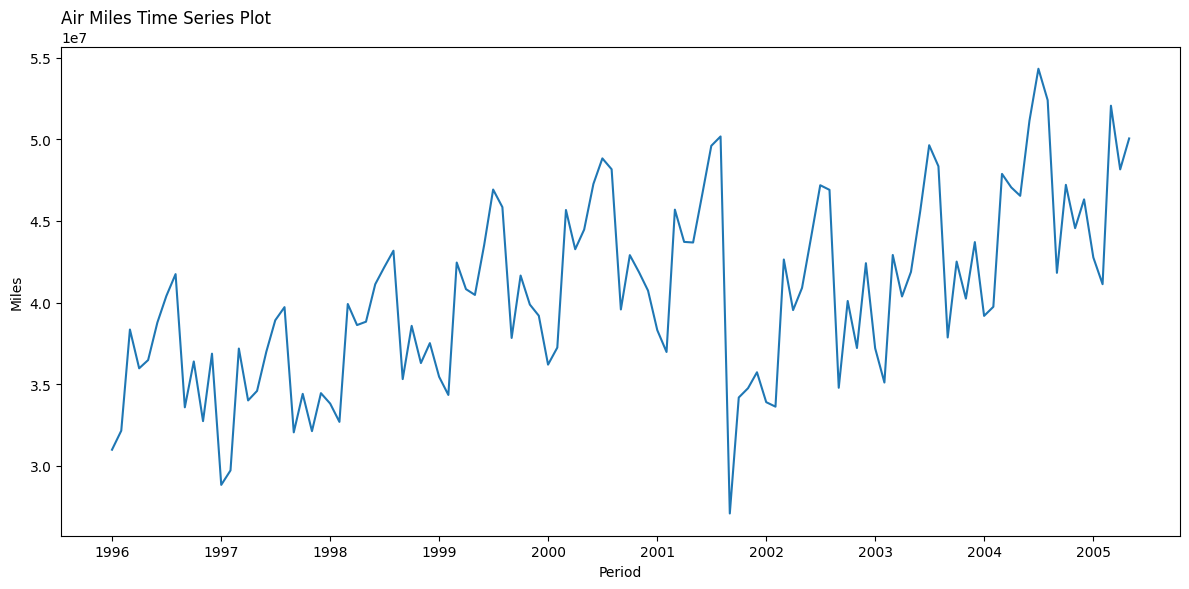

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.xlabel("Period")
plt.ylabel("Miles")
plt.title("Air Miles Time Series Plot", loc="left")
plt.tight_layout()
plt.show()

### Month Plot

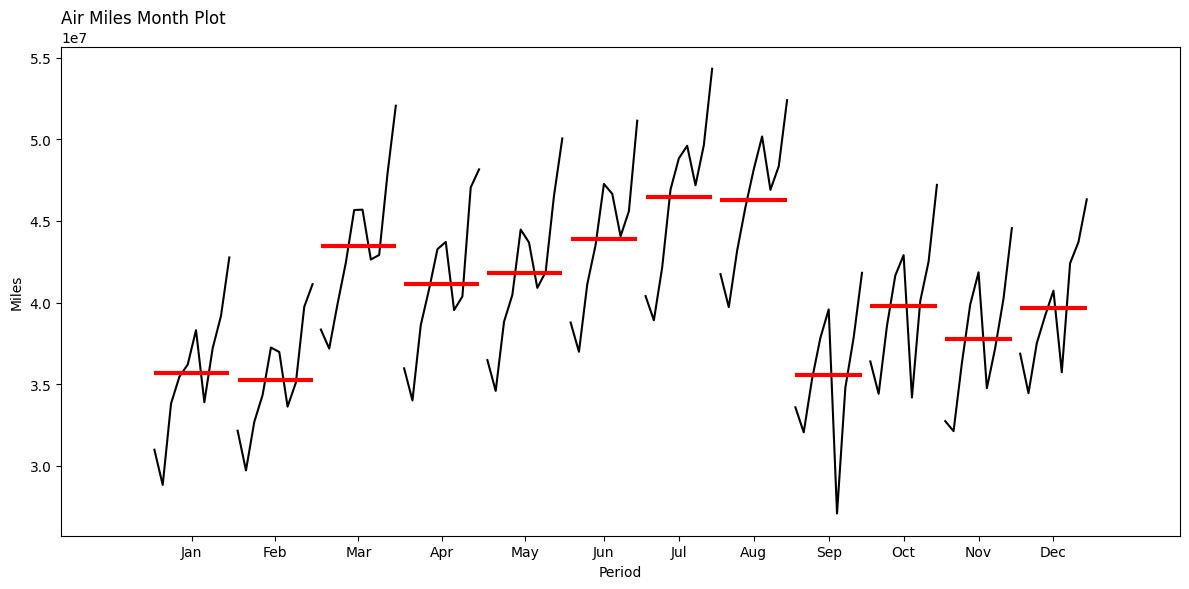

In [71]:
fig, ax = plt.subplots(figsize=(12, 6))
month_plot(df, ax=ax)
plt.xlabel("Period")
plt.ylabel("Miles")
plt.title("Air Miles Month Plot", loc="left")
plt.tight_layout()
plt.show()

### Checking **Trend** model type: Additive or Multiplicative?

It will be tested on models versions

### Checking **Seasonal** model type: Additive or Multiplicative?

In [73]:
add = seasonal_decompose(df, model="additive")
mul = seasonal_decompose(df, model="multiplicative")

In [77]:
add_error = add.resid.dropna().std()
mul_error = mul.resid.dropna().std()

print(f"Additive Model Error: {add_error}")
print(f"Multiplicative Model Error: {mul_error}")

Additive Model Error: 1494567.603015613
Multiplicative Model Error: 0.03851062765655755


The model with the lowest error is the **Multiplicative** for Seasonality.

### Checking Seasonality and Autocorrelation

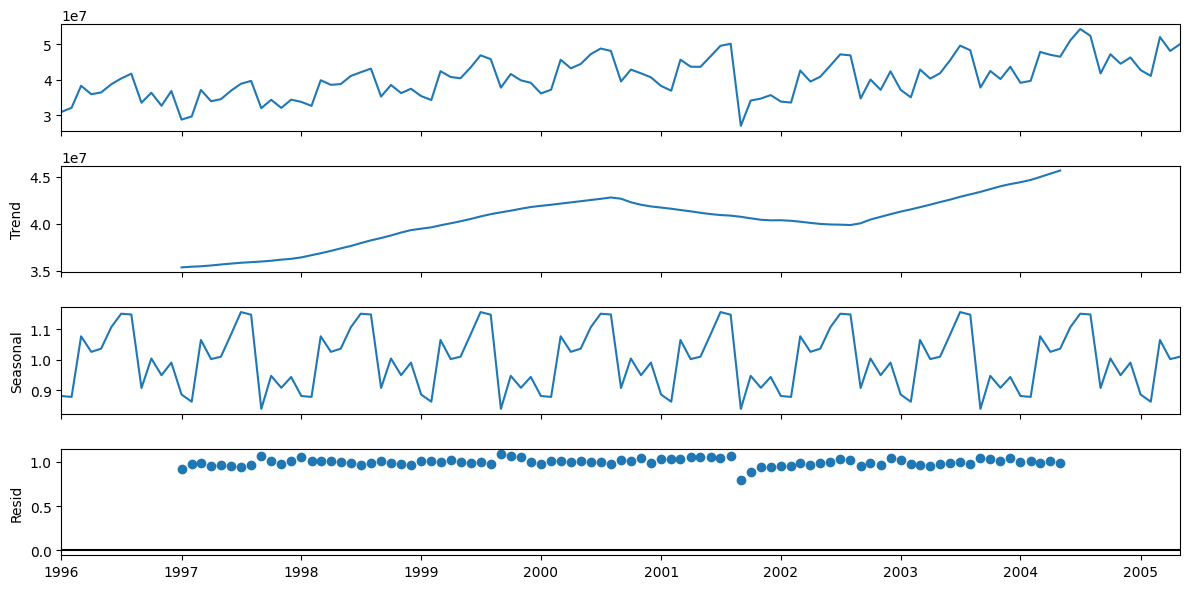

In [81]:
decomposition = seasonal_decompose(df, model="multiplicative", period=24)

fig = decomposition.plot()
fig.set_tight_layout(tight=True)
fig.set_size_inches((12,6 ))
plt.show()

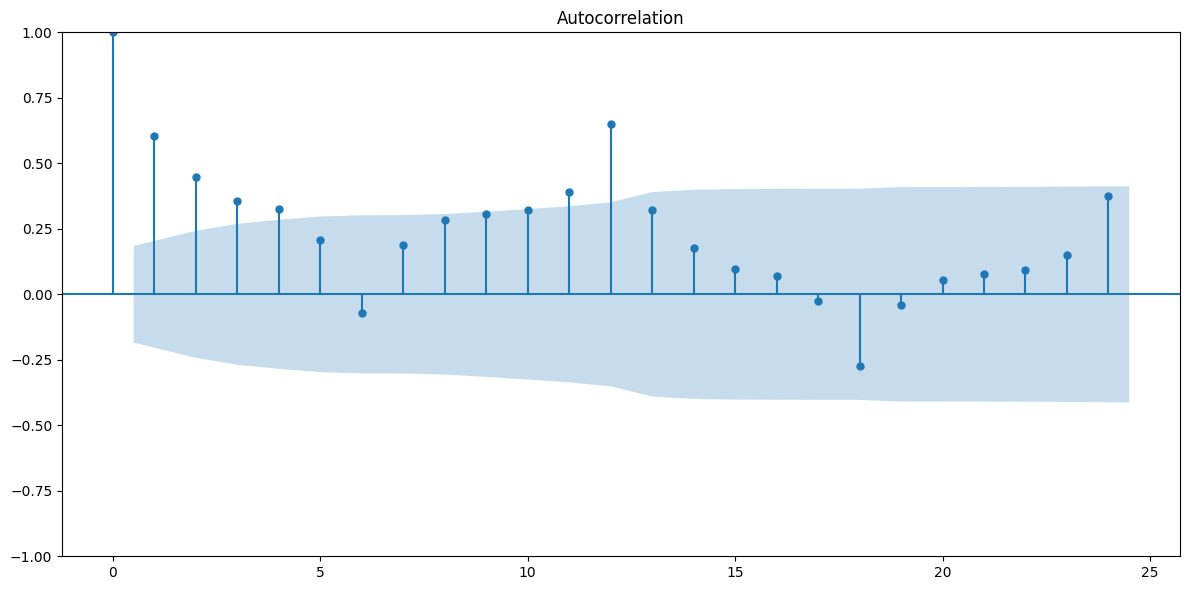

In [84]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df, lags=24, ax=ax)
plt.tight_layout()
plt.show()

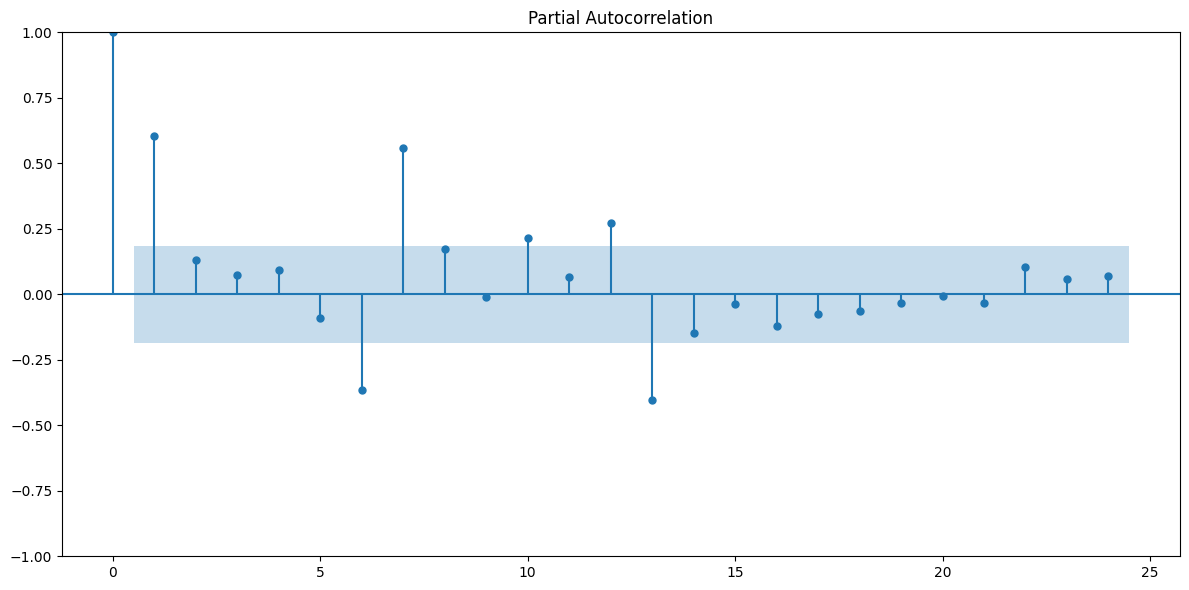

In [85]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df, lags=24, ax=ax)
plt.tight_layout()
plt.show()

## Creating Model

In [92]:
def measuring_predictions(y_true: pd.Series, y_pred: pd.Series):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    accuracy = 1 - mape

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")
    print(f"Model's Accuracy: {accuracy * 100:.2f}%")

In [112]:
def model_assessment(train, test, predictions, chart_title: None):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Training Data")
    plt.plot(test, label="Testing Data")
    plt.plot(predictions, label="Prediction Data", ls="--")
    plt.title(chart_title, loc="left")
    plt.xlabel("Periods")
    plt.ylabel("Complaints")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Break data into Train and Test

In [113]:
periods = 12
train = df[:-12]
test = df[-12:]

In [117]:
model_v1 = ExponentialSmoothing(
    endog=train, 
    trend="mul",
    seasonal="mul",
    seasonal_periods=24
).fit()

result_v1 = model_v1.forecast(periods)

measuring_predictions(test, result_v1)

Mean Absolute Error: 1421076.61
Root Mean Squared Error: 1709852.02
Mean Absolute Percentage Error: 2.94%
Model's Accuracy: 97.06%


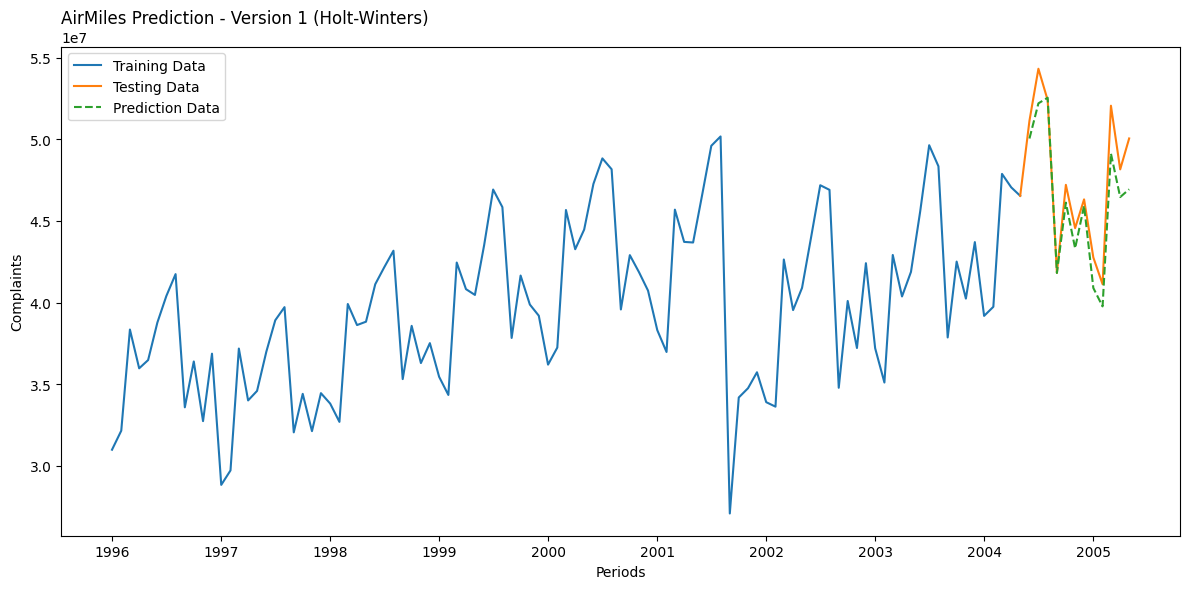

In [118]:
model_assessment(train, pd.concat([train[-1:], test]), result_v1, "AirMiles Prediction - Version 1 (Holt-Winters)")

In [125]:
model_v2 = ExponentialSmoothing(
    endog=train, 
    trend="add",
    seasonal="mul",
    seasonal_periods=24
).fit()

result_v2 = model_v2.forecast(periods)

measuring_predictions(test, result_v2)

Mean Absolute Error: 1581109.24
Root Mean Squared Error: 1886637.42
Mean Absolute Percentage Error: 3.29%
Model's Accuracy: 96.71%


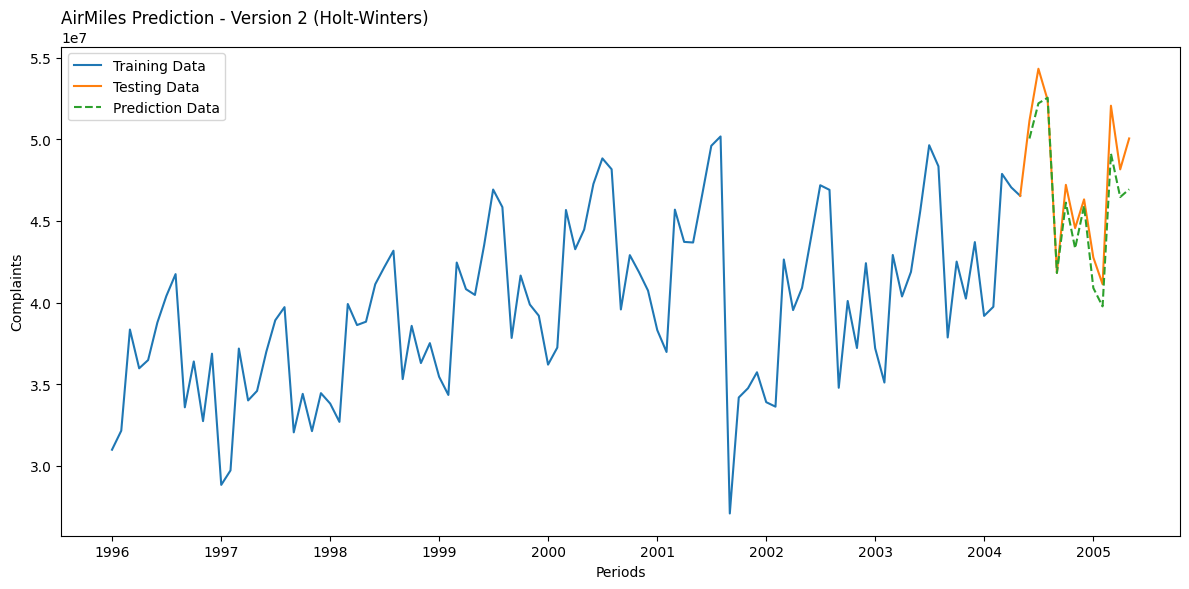

In [126]:
model_assessment(train, pd.concat([train[-1:], test]), result_v1, "AirMiles Prediction - Version 2 (Holt-Winters)")

In [127]:
model_v3 = ExponentialSmoothing(
    endog=train, 
    trend="mul",
    seasonal="mul",
    seasonal_periods=12
).fit()

result_v3 = model_v3.forecast(periods)

measuring_predictions(test, result_v3)

Mean Absolute Error: 1375679.66
Root Mean Squared Error: 1485759.07
Mean Absolute Percentage Error: 2.90%
Model's Accuracy: 97.10%


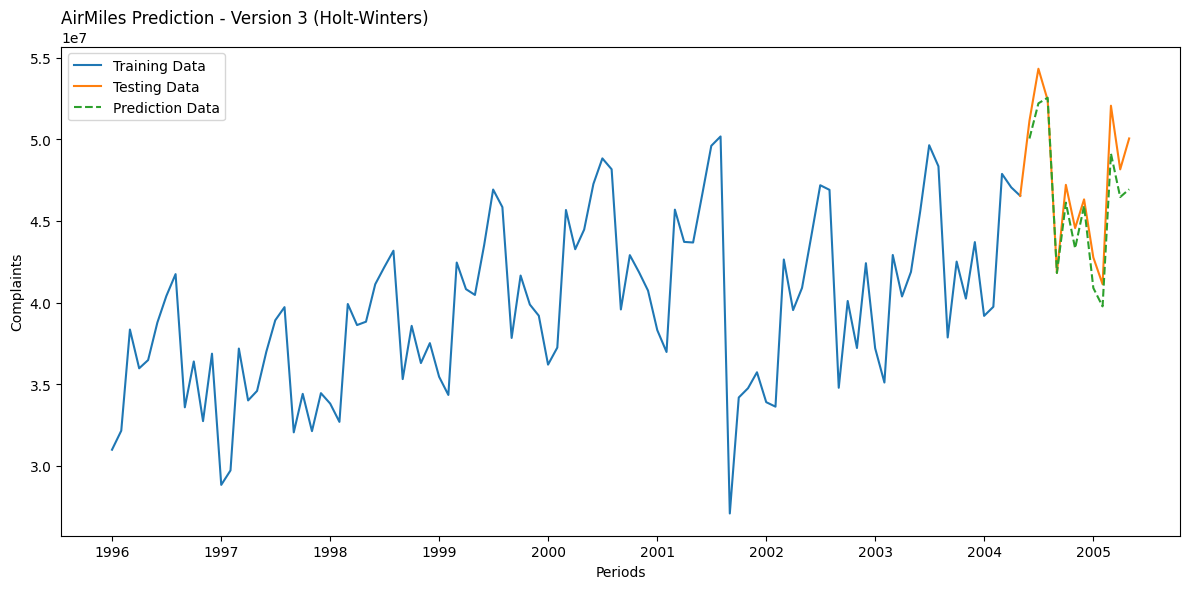

In [128]:
model_assessment(train, pd.concat([train[-1:], test]), result_v1, "AirMiles Prediction - Version 3 (Holt-Winters)")

In [135]:
required_params = {
    "trend": ["add", "mul"],
    "seasonal": ["add", "mul"],
    "seasonal_periods": [6, 12, 18, 24],
}

model_params = []
for t in required_params["trend"]:
    for s in required_params["seasonal"]:
        for sp in required_params["seasonal_periods"]:
            model_params.append({
                "trend": t,
                "seasonal": s,
                "seasonal_periods": sp,
            })

In [141]:
output_result = []
for param in model_params:
    model = ExponentialSmoothing(
        endog=train,
        trend=param["trend"],
        seasonal=param["seasonal"],
        seasonal_periods=param["seasonal_periods"]
    ).fit()

    result = model.forecast(periods)

    mape = mean_absolute_percentage_error(test, result)

    output_result.append(
        {
            "trend": param["trend"],
            "seasonal": param["seasonal"],
            "seasonal_periods": param["seasonal_periods"],
            "AIC": model.aic,
            "MAPE": 100 - (round(mape, 5) * 100)
        }
    )

c:\development\time_series_course\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [142]:
output_result

[{'trend': 'add',
  'seasonal': 'add',
  'seasonal_periods': 6,
  'AIC': np.float64(3109.060694971559),
  'MAPE': 92.168},
 {'trend': 'add',
  'seasonal': 'add',
  'seasonal_periods': 12,
  'AIC': np.float64(2952.491327896432),
  'MAPE': 97.065},
 {'trend': 'add',
  'seasonal': 'add',
  'seasonal_periods': 18,
  'AIC': np.float64(3129.4025751896265),
  'MAPE': 93.019},
 {'trend': 'add',
  'seasonal': 'add',
  'seasonal_periods': 24,
  'AIC': np.float64(2943.9968142754988),
  'MAPE': 97.094},
 {'trend': 'add',
  'seasonal': 'mul',
  'seasonal_periods': 6,
  'AIC': np.float64(3104.079601905612),
  'MAPE': 92.113},
 {'trend': 'add',
  'seasonal': 'mul',
  'seasonal_periods': 12,
  'AIC': np.float64(2919.3147232635984),
  'MAPE': 96.852},
 {'trend': 'add',
  'seasonal': 'mul',
  'seasonal_periods': 18,
  'AIC': np.float64(3123.789514155243),
  'MAPE': 91.814},
 {'trend': 'add',
  'seasonal': 'mul',
  'seasonal_periods': 24,
  'AIC': np.float64(2922.798782625162),
  'MAPE': 96.713},
 {'tren

## Creating Final Model

In [143]:
model_hw = ExponentialSmoothing(
    endog=df, 
    trend="mul",
    seasonal="mul",
    seasonal_periods=12
).fit()

result_hw = model_hw.forecast(periods)

In [145]:
result_hw

2005-06-01    5.333950e+07
2005-07-01    5.645171e+07
2005-08-01    5.616236e+07
2005-09-01    4.298743e+07
2005-10-01    4.825182e+07
2005-11-01    4.579836e+07
2005-12-01    4.804130e+07
2006-01-01    4.379656e+07
2006-02-01    4.327078e+07
2006-03-01    5.336326e+07
2006-04-01    5.053895e+07
2006-05-01    5.132620e+07
Freq: MS, dtype: float64

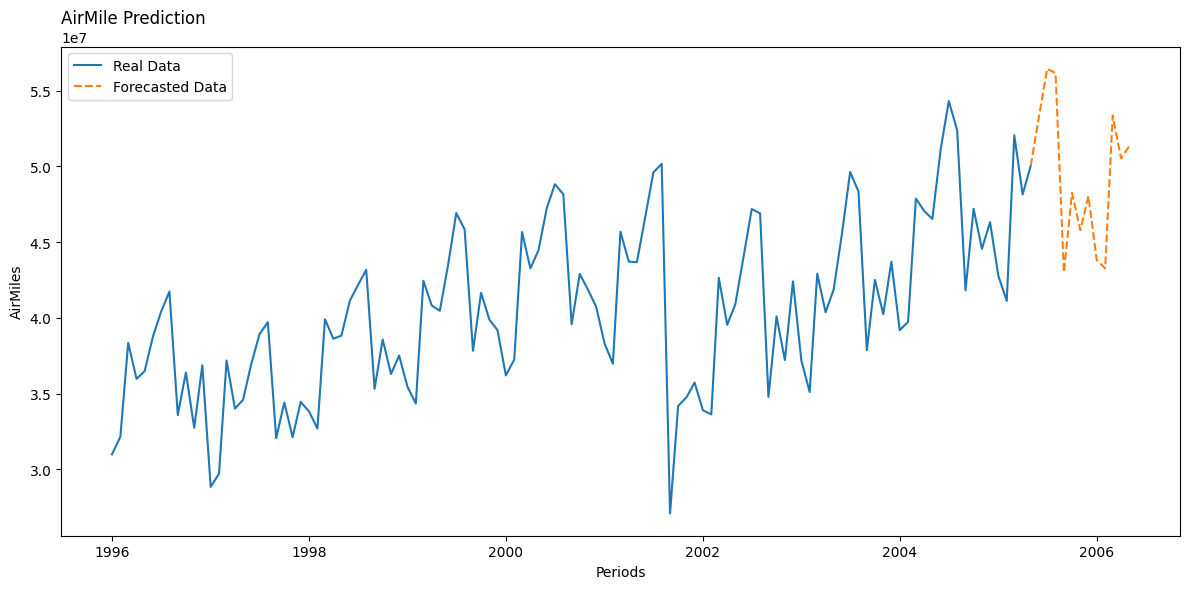

In [161]:
plt.figure(figsize=(12, 6))
plt.plot(df, label="Real Data")
plt.plot(pd.concat([df[-1:]["airmiles"], result_hw], axis=0), label="Forecasted Data", ls="--")
plt.ylabel("AirMiles")
plt.xlabel("Periods")
plt.title("AirMile Prediction", loc="left")
plt.legend()
plt.tight_layout()
plt.show()